# Import tools and libraries

In [13]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import matplotlib as mpl
import geopandas
## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
#from scipy.stats import shapiro  #check normalicy of seasonal trend distribution
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der, least_squares
from sklearn.preprocessing import StandardScaler
import pickle

##import functions for fitting
from symfit import parameters, variables, Fit
from symfit import pi,sqrt,log,exp,sinh
from symfit import sin, cos


# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/tristan/mesmer/tools')
#from tools.loading import load_data_single_mod
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
import mplotutils as mpu
import seaborn as sns

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed
#loading data
from sklearn.externals import joblib
from matplotlib.colors import from_levels_and_colors
from matplotlib.colors import LogNorm, Normalize,LinearSegmentedColormap

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Load in data

In [2]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  ## is this needed??

## Load observation data

In [3]:
#Get directory
dir_in_data_mod = '/home/tristan/mesmer/output/'
    
#prepare the inputs as array
BEST_data = 'obs_data_25.nc'

# load in observation data
df_obs = xr.open_mfdataset(dir_in_geo_dist+BEST_data).roll(lon=72) #open observation data

#create test data over date range - here, 3 years (1910 incl and up to 2022)
data_test = np.array([df_obs.temperature.values[1980:2016,idx_l]]) 
clim_test = np.array([df_obs.climatology.values[:,idx_l]]) 

data_test = data_test.reshape(36,idx_l.sum())
clim_test = clim_test.reshape(12,idx_l.sum())

print(data_test.shape)
# print(data_test.shape)

# repeat climatology values
y_ma = np.zeros((12*3,3043))  #create emtpy array with correct shape
for i in range(12*3):
    y_ma[i] = df_obs.climatology.values[i%12,idx_l]    #fill climatology values in the array
        
# create array with monthly observation temperatures by adding the climatology and the residues -> subtract yearly temperature anomoly
y_all_mon = np.add(y_ma, data_test)

# now subtract the yearly average climatology so we are left with residuals
y_all_mon = y_all_mon - np.reshape(np.tile(np.mean(df_obs.climatology.values[:,idx_l],axis=0),36),(36,idx_l.sum()))   
print(y_all_mon.shape)

(36, 3043)
(36, 3043)


## Load training data

In [15]:
# load training data, starts at 1910
train_ds = joblib.load(dir_in_data_mod+'seasonal_training_results.pkl')

# slice training data for the correct time range - starts at 1910! 
train_slice = np.array(train_ds[1260:1296,:])

# check shape
print(train_slice.shape)

(36, 3043)


## Slice the data for the correct grid point

In [16]:
# "Central Europe"
cnt_eur_obs = y_all_mon[:,2016:2017]
cnt_eur_train = train_slice[:,2016:2017]

# "South America"
s_america_obs = y_all_mon[:,217:218]
s_america_train = train_slice[:,217:218]

# "Central Africa"
c_africa_obs = y_all_mon[:,645:646]
c_africa_train = train_slice[:,645:646]
print(c_africa_train.shape)

# create the datetime column for the graph
t = np.arange("2014-01", "2017-01", dtype='datetime64[M]')

#check that the shape is correct
print(t.shape)

(36, 1)
(36,)


In [17]:
# set plot params

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
          'figure.figsize': (9,5),
          "font.family": "tahoma",
         'ytick.labelsize':'x-large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

In [18]:
## add land mask
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  #

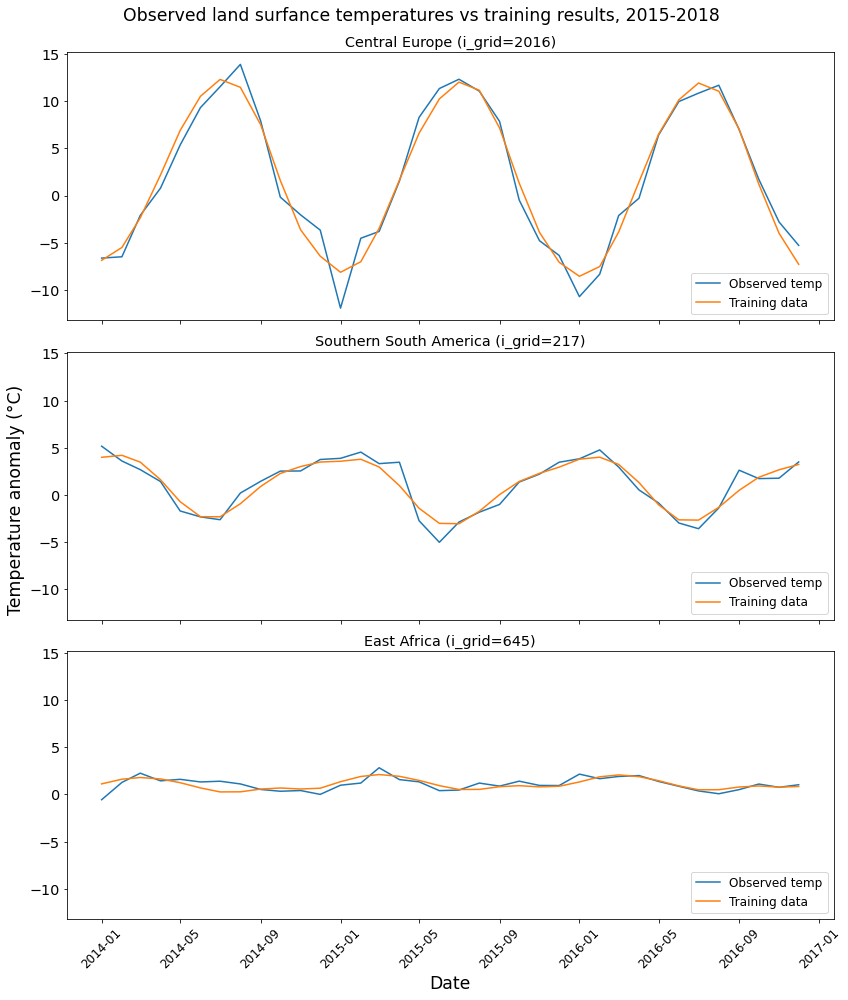

In [37]:
# define plot space
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,14), sharex=True, sharey=True)

# definte x and y axes 
## for Central Europe
ax1.plot(t, 
        cnt_eur_obs,
       label="Observed temp")
ax1.plot(t,
       cnt_eur_train,
       label="Training data")
ax1.legend(loc="lower right")

## for South America
ax2.plot(t, 
        s_america_obs,
       label="Observed temp")
ax2.plot(t,
       s_america_train,
       label="Training data")
ax2.legend(loc="lower right")

## for Central Africa
ax3.plot(t, 
        c_africa_obs,
       label="Observed temp")
ax3.plot(t,
       c_africa_train,
       label="Training data")
ax3.legend(loc="lower right")

# set plot title and axes labels 
## for Central Europe
ax1.set(title = "Central Europe (i_grid=2016)")
plt.setp(ax1.get_xticklabels(), rotation=45)

## for South America
ax2.set(title = "Southern South America (i_grid=217)")
plt.setp(ax2.get_xticklabels(), rotation=45)

## for Central Africa
ax3.set(title = "East Africa (i_grid=645)",
       xlabel = "Date")
plt.setp(ax3.get_xticklabels(), rotation=45)

fig.suptitle('Observed land surfance temperatures vs training results, 2015-2018', va='center', fontsize='xx-large')
fig.supylabel("Temperature anomaly (°C)", fontsize='xx-large')

fig.tight_layout()
plt.show()


In [10]:
## plot the observed land surface trend from BEST ORIGINAL dataset

#Get directory
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'BEST_1deg_datefix.nc'

# load in observation data
df_obs = xr.open_mfdataset(dir_in_geo_dist+BEST_data).roll(longitude=72)
df_obs.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 3265, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) datetime64[ns] 1750-01-31 1750-02-28 ... 2022-01-31
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    temperature  (time, latitude, longitude) float32 dask.array<chunksize=(3265, 180, 360), meta=np.ndarray>
    climatology  (month_number, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:          Berkeley Earth Internal Convention (based on CF-1.5)
    title:                Gridded Berkeley Earth Surface Temperature Anomaly ...
    history:              10-Feb-2022 17:30:05
    institution:         

In [11]:
lat = 52.5
lon = 14.5

#correct slice the years
start_date = "1850-01-31"
end_date = "2022-01-31"

y_all_mon = df_obs
temp_record = df_obs["temperature"].sel(time=slice(start_date, end_date),
                                                   longitude=lon, 
                                                   latitude=lat)

temp_record


<xarray.DataArray 'temperature' (time: 2065)>
dask.array<getitem, shape=(2065,), dtype=float32, chunksize=(2065,), chunktype=numpy.ndarray>
Coordinates:
    longitude  float32 14.5
    latitude   float32 52.5
  * time       (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2022-01-31
Attributes:
    units:          degree C
    standard_name:  surface_temperature_anomaly
    long_name:      Air Surface Temperature Anomaly
    valid_min:      -16.354581211910208
    valid_max:      17.688969845646618

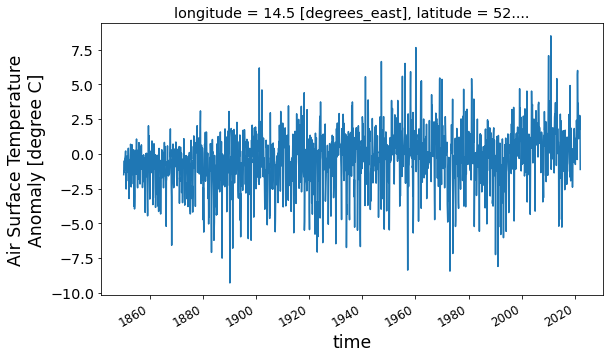

In [12]:
temp_record.plot()

plt.show()

In [13]:
#Get directory
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'BEST_1deg_datefix.nc'

# load in one degree original observation data
df_obs = xr.open_mfdataset(dir_in_geo_dist+BEST_data).roll(longitude=72)

#create test data over date range 
data_test = np.squeeze(np.array([df_obs.temperature.values])) 
clim_test = np.squeeze(np.array([df_obs.climatology.values])) 

data_test = data_test.reshape(tot_months,idx_l.sum())
# clim_test = clim_test.reshape(12,idx_l.sum())

print(data_test.shape)
print(clim_test.shape)
# print(data_test.shape)

# repeat climatology values
y_ma = np.zeros((tot_months,3043))  #create emtpy array with correct shape
for i in range(tot_months):
    y_ma[i] = df_obs.climatology.values[i%12,idx_l]    #fill climatology values in the array
        
# create array with monthly observation temperatures by adding the climatology and the residues -> subtract yearly temperature anomoly
y_all_mon = np.add(y_ma, data_test)

# now subtract the yearly average climatology so we are left with residuals
y_all_mon = y_all_mon - np.reshape(np.tile(np.mean(df_obs.climatology.values[:,idx_l],axis=0),tot_months),(tot_months,idx_l.sum()))   
print(y_all_mon.shape)
lat = 52.5
lon = 14.5

#correct slice the years
start_date = "1850-01-31"
end_date = "2021-12-31"

y_all_mon = df_obs
temp_record = df_obs["temperature"].sel(time=slice(start_date, end_date),
                                                   longitude=lon, 
                                                   latitude=lat)

best_one_deg = np.array(temp_record)
#########

time = np.arange(np.datetime64('1850-01-15'), np.datetime64('2022-01-15'), dtype='datetime64[M]')
print(time.shape)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(time,
       best_one_deg)
plt.show()

#calculate trendline


NameError: name 'tot_months' is not defined

(324, 1)
(172,)


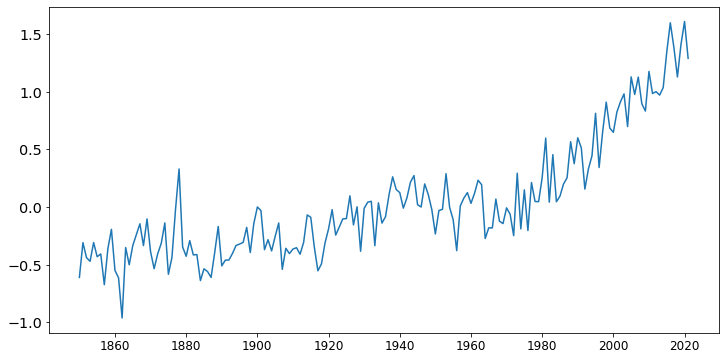

In [47]:
######### calculate annual average across all grid cells

y_all = np.mean(y_all_mon.reshape(-1,12,idx_l.sum()),axis=1)
y_all_mean = np.nanmean(y_all, axis=1)
print(y_all_mean.shape)

time = np.arange(np.datetime64('1850-01-15'), np.datetime64('2022-01-15'), dtype='datetime64[Y]')


############# plotting

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(time,
       y_all_mean)
plt.show()

#calculate trendline